# Understanding AutoEncoders with an example: a step-by-step tutorial
## [Part I](https://medium.com/p/693c3a4e9836) and [Part II](https://medium.com/p/a79d2ea2945e)

## By Daniel Voigt Godoy
### Author of ["Deep Learning with PyTorch Step-by-Step"](https://pytorchstepbystep.com)

### This is the accompanying notebook of my blog post, click on the title above to read it!

In [5]:
# Unfortunately, reproducibility is not guaranteed across different versions
# If you want to reproduce the outputs, you'll need to use PyTorch LTS version

# !pip3 install torch==1.8.2+cu102 torchvision==0.9.2+cu102 torchaudio==0.8.2 -f https://download.pytorch.org/whl/lts/1.8/torch_lts.html

In [1]:
try:
    import google.colab
    import subprocess
    import os

    if not os.path.exists('src'):
        os.mkdir('src')
        if not os.path.exists('src/autoencoders.py'):
            url = "https://raw.githubusercontent.com/dvgodoy/AccompanyingNotebooks/main/src/autoencoders.py"
            result = subprocess.run(["wget", "--no-cache", "--backups=1", url], stderr=subprocess.PIPE, stdout=subprocess.PIPE)
            print(result.stderr.decode("utf-8"))
            os.rename('autoencoders.py', 'src/autoencoders.py')
    if not os.path.exists('images/autoencoders'):
        os.makedirs('images/autoencoders')
        if not os.path.exists('images/autoencoders/duck_mnist.png'):
            url = "https://raw.githubusercontent.com/dvgodoy/AccompanyingNotebooks/main/images/autoencoders/duck_mnist.png"
            result = subprocess.run(["wget", "--no-cache", "--backups=1", url], stderr=subprocess.PIPE, stdout=subprocess.PIPE)
            print(result.stderr.decode("utf-8"))
            os.rename('duck_mnist.png', 'images/autoencoders/duck_mnist.png')
except ModuleNotFoundError:
    pass

from src.autoencoders import *

# Part I - Vanilla AutoEncoders

## An MNIST-like Dataset of Circles

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import torch
from PIL import Image
from torch.utils.data import TensorDataset, DataLoader

def draw_circle(radius, center_x=0.5, center_y=0.5, size=28):
    # draw a circle using coordinates for the center, and the radius
    circle = plt.Circle((center_x, center_y), radius, color='k', fill=False)
    fig, ax = plt.subplots(figsize=(1, 1))
    ax.add_patch(circle)
    ax.axis('off')
    buf = fig.canvas.print_to_buffer()
    plt.close()
    # converts matplotlib figure into PIL image, make it grayscale, and resize it
    return np.array(Image.frombuffer('RGBA', buf[1], buf[0]).convert('L').resize((int(size), int(size))))

def gen_circles(n, size=28):
    # generates random coordinates around (0.5, 0.5) as center points
    center_x = np.random.uniform(0.0, 0.03, size=n).reshape(-1, 1)+.5
    center_y = np.random.uniform(0.0, 0.03, size=n).reshape(-1, 1)+.5
    # generates random radius sizes between 0.03 and 0.47
    radius = np.random.uniform(0.03, 0.47, size=n).reshape(-1, 1)
    sizes = np.ones((n, 1))*size

    coords = np.concatenate([radius, center_x, center_y, sizes], axis=1)
    # generates circles using draw_circle function
    circles = np.apply_along_axis(func1d=lambda v: draw_circle(*v), axis=1, arr=coords)
    return circles, radius

np.random.seed(42)
# generates 1,000 circles
circles, radius = gen_circles(1000)

circles_ds = TensorDataset(torch.as_tensor(circles).unsqueeze(1).float()/255, torch.as_tensor(radius))
circles_dl = DataLoader(circles_ds, batch_size=32, shuffle=True, drop_last=True)

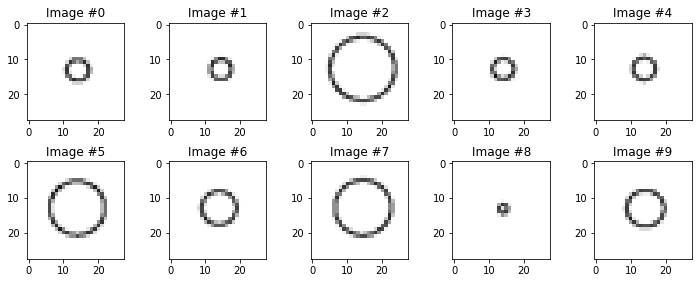

In [4]:
fig = figure1(circles_ds)

## The Encoder

![encoder](images/autoencoders/encoder_diagram.png)

In [4]:
import torch.nn as nn

def set_seed(self, seed=42):
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    torch.manual_seed(seed)
    np.random.seed(seed)

class Encoder(nn.Module):
    def __init__(self, input_shape, z_size, base_model):
        super().__init__()
        self.input_shape = input_shape
        self.z_size = z_size
        self.base_model = base_model
        
        # appends the "lin_latent" linear layer to map from "output_size" 
        # given by the base model to desired size of the representation (z_size)
        output_size = self._get_output_size()
        self.lin_latent = nn.Linear(output_size, z_size)
        
    def _get_output_size(self):
        # builds a dummy batch containing one dummy tensor
        # full of zeroes with the same shape as the inputs
        device = next(self.base_model.parameters()).device.type
        dummy = torch.zeros(1, *self.input_shape, device=device)
        # sends the dummy batch through the base model to get 
        # the output size produced by it
        size = self.base_model(dummy).size(1)
        return size
        
    def forward(self, x):
        # forwards the input through the base model and then the "lin_latent" layer 
        # to get the representation (z)
        base_out = self.base_model(x)
        out = self.lin_latent(base_out)        
        return out

set_seed(13)

# we defined our representation (z) as a vector of size one
z_size = 1
# our images are 1@28x28
input_shape = (1, 28, 28) # (C, H, W)

base_model = nn.Sequential(
    # (C, H, W) -> C*H*W
    nn.Flatten(),
    # C*H*W -> 2048
    nn.Linear(np.prod(input_shape), 2048),
    nn.LeakyReLU(),
    # 2048 -> 2048
    nn.Linear(2048, 2048),
    nn.LeakyReLU(),
)

encoder = Encoder(input_shape, z_size, base_model)

In [5]:
encoder

Encoder(
  (base_model): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=784, out_features=2048, bias=True)
    (2): LeakyReLU(negative_slope=0.01)
    (3): Linear(in_features=2048, out_features=2048, bias=True)
    (4): LeakyReLU(negative_slope=0.01)
  )
  (lin_latent): Linear(in_features=2048, out_features=1, bias=True)
)

In [6]:
x, _ = circles_ds[7]
z = encoder(x)
z

tensor([[-0.1314]], grad_fn=<AddmmBackward>)

## Latent Space

![latent space](images/autoencoders/latent_space.png)

## The Decoder

![decoder](images/autoencoders/decoder_diagram.png)

In [7]:
decoder = nn.Sequential(
    # z_size -> 2048
    nn.Linear(z_size, 2048),
    nn.LeakyReLU(),
    # 2048 -> 2048
    nn.Linear(2048, 2048),
    nn.LeakyReLU(),
    # 2048 -> C*H*W
    nn.Linear(2048, np.prod(input_shape)),
    # C*H*W -> (C, H, W)
    nn.Unflatten(1, input_shape)
)

In [8]:
decoder

Sequential(
  (0): Linear(in_features=1, out_features=2048, bias=True)
  (1): LeakyReLU(negative_slope=0.01)
  (2): Linear(in_features=2048, out_features=2048, bias=True)
  (3): LeakyReLU(negative_slope=0.01)
  (4): Linear(in_features=2048, out_features=784, bias=True)
  (5): Unflatten(dim=1, unflattened_size=(1, 28, 28))
)

In [9]:
x_tilde = decoder(z)
x_tilde, x_tilde.shape

(tensor([[[[ 1.9056e-01, -4.4774e-02, -4.8989e-02,  5.2036e-02, -7.9089e-02,
            -1.6500e-01,  3.9518e-02,  6.4876e-02, -3.7528e-02, -3.6638e-02,
             2.3305e-02, -1.2362e-01,  2.0495e-01,  1.3523e-01,  1.0159e-03,
             1.2092e-02, -1.3440e-01, -3.8864e-02,  6.2095e-02, -3.1591e-02,
            -7.5479e-02, -1.5529e-02, -6.5137e-02, -1.5788e-01, -9.7554e-02,
             5.3229e-02,  6.6569e-02, -2.6308e-02],
           [ 1.8886e-01,  9.6826e-02, -1.4002e-01, -1.2959e-01, -1.0598e-02,
             5.7292e-02, -7.6855e-02,  5.4083e-02,  6.5022e-02, -1.6511e-01,
            -5.0334e-02,  6.3009e-02,  9.9231e-02, -2.2333e-02, -1.1332e-01,
             1.6136e-01, -1.4600e-01,  2.0025e-01, -2.7123e-02,  6.4258e-02,
            -9.6863e-02,  3.2772e-02, -6.9126e-02,  1.1296e-01,  8.7233e-02,
            -1.4546e-02,  1.9607e-01,  1.1790e-01],
           [-7.3337e-02,  9.0205e-02, -4.3713e-02,  1.1455e-01,  6.9888e-02,
             2.1058e-03, -4.2400e-02,  1.4121e-01

## AutoEncoder (AE)

![autoencoder](images/autoencoders/ae_diagram.png)

In [10]:
class AutoEncoder(nn.Module):
    def __init__(self, encoder, decoder):
        super().__init__()
        self.enc = encoder
        self.dec = decoder
        
    def forward(self, x):
        # when encoder met decoder
        enc_out = self.enc(x)
        return self.dec(enc_out)
    
model_ae = AutoEncoder(encoder, decoder)

In [11]:
model_ae

AutoEncoder(
  (enc): Encoder(
    (base_model): Sequential(
      (0): Flatten(start_dim=1, end_dim=-1)
      (1): Linear(in_features=784, out_features=2048, bias=True)
      (2): LeakyReLU(negative_slope=0.01)
      (3): Linear(in_features=2048, out_features=2048, bias=True)
      (4): LeakyReLU(negative_slope=0.01)
    )
    (lin_latent): Linear(in_features=2048, out_features=1, bias=True)
  )
  (dec): Sequential(
    (0): Linear(in_features=1, out_features=2048, bias=True)
    (1): LeakyReLU(negative_slope=0.01)
    (2): Linear(in_features=2048, out_features=2048, bias=True)
    (3): LeakyReLU(negative_slope=0.01)
    (4): Linear(in_features=2048, out_features=784, bias=True)
    (5): Unflatten(dim=1, unflattened_size=(1, 28, 28))
  )
)

![mirror layers](images/autoencoders/enc_dec_mirror.png)

### Model Training (AE)

In [12]:
set_seed(13)

device = 'cuda' if torch.cuda.is_available() else 'cpu'
model_ae.to(device)
loss_fn = nn.MSELoss()
optim = torch.optim.Adam(model_ae.parameters(), 0.0003)

num_epochs = 10

train_losses = []

for epoch in range(1, num_epochs+1):
    batch_losses = []
    for i, (x, _) in enumerate(circles_dl):
        model_ae.train()
        x = x.to(device)

        # Step 1 - Computes our model's predicted output - forward pass
        yhat = model_ae(x)
        # Step 2 - Computes the loss
        loss = loss_fn(yhat, x) 
        # Step 3 - Computes gradients
        loss.backward()
        # Step 4 - Updates parameters using gradients and the learning rate
        optim.step()
        optim.zero_grad()
        
        batch_losses.append(np.array([loss.data.item()]))

    # Average over batches
    train_losses.append(np.array(batch_losses).mean(axis=0))

    print(f'Epoch {epoch:03d} | Loss >> {train_losses[-1][0]:.4f}')

Epoch 001 | Loss >> 0.1535
Epoch 002 | Loss >> 0.0220
Epoch 003 | Loss >> 0.0206
Epoch 004 | Loss >> 0.0200
Epoch 005 | Loss >> 0.0167
Epoch 006 | Loss >> 0.0159
Epoch 007 | Loss >> 0.0149
Epoch 008 | Loss >> 0.0132
Epoch 009 | Loss >> 0.0117
Epoch 010 | Loss >> 0.0109


### Example of Reconstruction

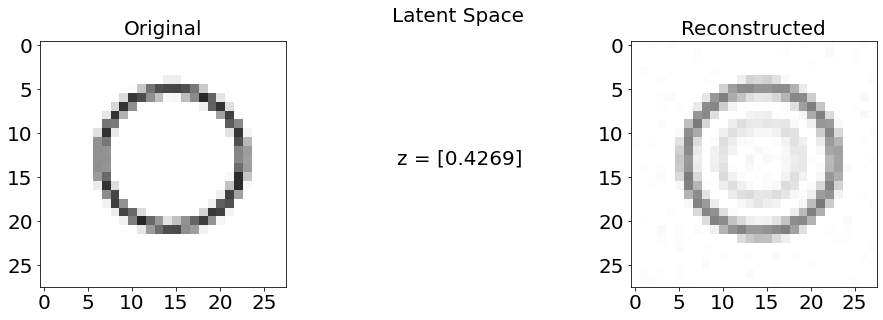

In [13]:
fig = figure2(model_ae, circles_ds[7][0], device)

### Latent Space Distribution (AE)

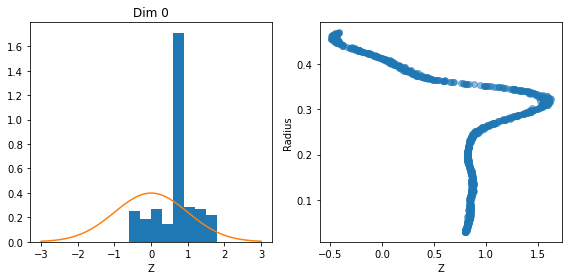

In [14]:
aeviz1 = AEViz(model_ae.enc, model_ae.dec, circles_dl)
fig, axs = plt.subplots(1, 2, figsize=(8, 4))
_ = aeviz1.plot_latent(ax=axs[1])
_ = aeviz1.plot_z_dist(n_cols=1, bins=np.linspace(-3, 3, 21), axs=axs[0])

### Reconstruction (AE)

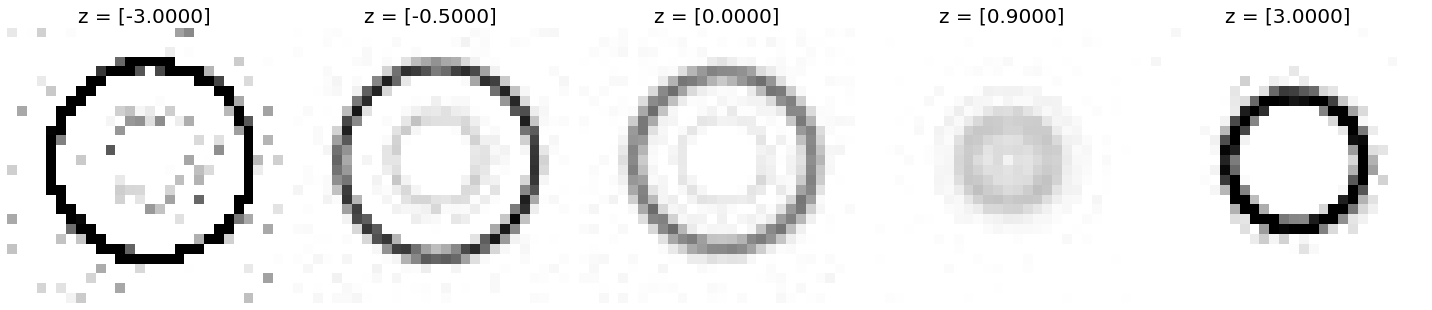

In [15]:
fig = figure4(model_ae, device)

## AutoEncoder as Anomaly Detectors

![duck mnist](images/autoencoders/duck_mnistified.png)

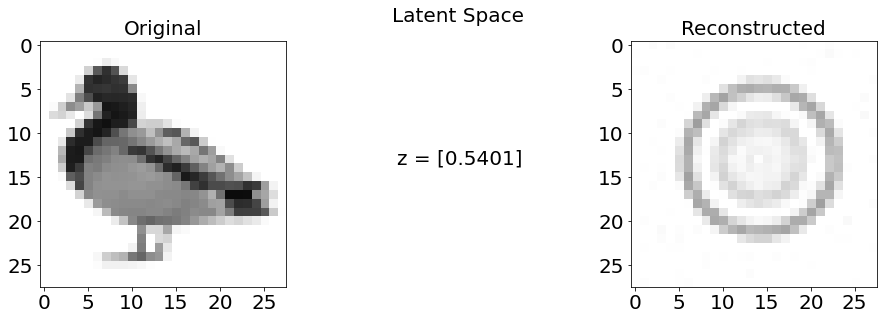

In [16]:
image_fname = 'images/autoencoders/duck_mnist.png'
fig = figure5(model_ae, image_fname, device)

# Part II - Variational AutoEncoders

## Variational AutoEncoder (VAE)

![vae](images/autoencoders/vae_diagram.png)

```EncoderVar(
  (base_model): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=784, out_features=2048, bias=True)
    (2): LeakyReLU(negative_slope=0.01)
    (3): Linear(in_features=2048, out_features=2048, bias=True)
    (4): LeakyReLU(negative_slope=0.01)
  )
  (lin_mu): Linear(in_features=2048, out_features=1, bias=True)
  (lin_var): Linear(in_features=2048, out_features=1, bias=True)
)```

### Reparametrization Trick

In [17]:
def forward(self, x):
    base_out = self.base_model(x)
        
    self.mu = self.lin_mu(base_out)
    self.log_var = self.lin_var(base_out)
    std = torch.exp(self.log_var/2)
                
    eps = torch.randn_like(self.mu)
    z = self.mu + eps * std
    return z

$$
\Large e^{\frac{\log\sigma^2}{2}} = e^{\frac{2\log\sigma}{2}} = e^{\log\sigma} = \sigma
$$

![](images/autoencoders/vae_diagram_reparam.png)

In [18]:
# from torch.distributions.normal.Normal

def sample(self, sample_shape=torch.Size()):
    shape = self._extended_shape(sample_shape)
    with torch.no_grad():
        return torch.normal(self.loc.expand(shape),
                            self.scale.expand(shape))

def rsample(self, sample_shape=torch.Size()):
    shape = self._extended_shape(sample_shape)
    eps = _standard_normal(shape, 
                           dtype=self.loc.dtype,
                           device=self.loc.device)
    return self.loc + eps * self.scale

### Kullback-Leibler Divergence/Loss

$$
\Large D_{KL}\left[N(\mu, \sigma) \parallel N(0, 1)\right] = -\frac{1}{2}\left(1 + \log\sigma^2 - \mu^2 - \sigma^2\right)
$$

In [19]:
def kl_div(mu, std):
    kl_div = -0.5*(1 + np.log(std**2) - mu**2 - std**2)
    return kl_div

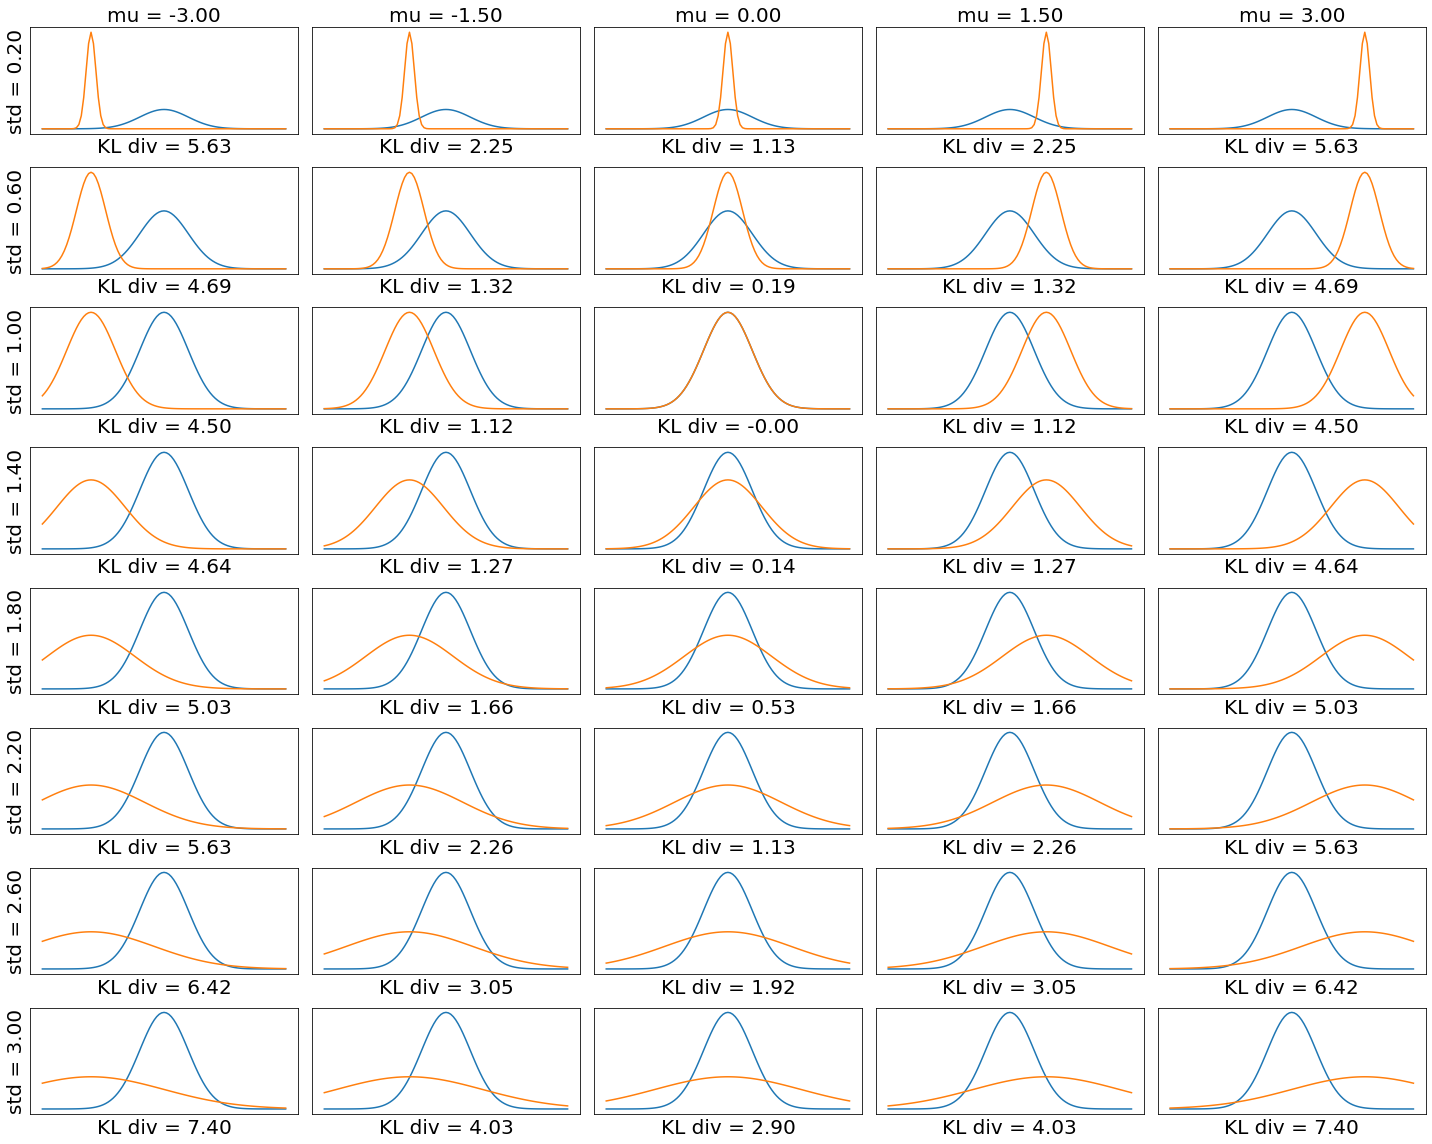

In [20]:
fig, mus, scales, divergences = figure6()

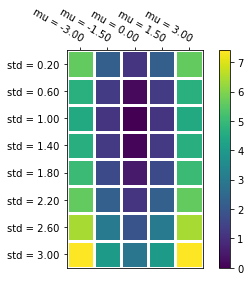

In [21]:
fig = figure7(mus, scales, divergences)

In [22]:
class EncoderVar(nn.Module):
    def __init__(self, input_shape, z_size, base_model):
        super().__init__()
        self.z_size = z_size
        self.input_shape = input_shape
        self.base_model = base_model
        output_size = self.get_output_size()
        self.lin_mu = nn.Linear(output_size, z_size)
        self.lin_var = nn.Linear(output_size, z_size)
        
    def get_output_size(self):
        device = next(self.base_model.parameters()).device.type
        size = self.base_model(torch.zeros(1, *self.input_shape, device=device)).size(1)
        return size
    
    def kl_loss(self):
        kl_loss = -0.5*(1 + self.log_var - self.mu**2 - torch.exp(self.log_var))
        return kl_loss
        
    def forward(self, x):
        # the base model, same as the traditional AE
        base_out = self.base_model(x)
        
        # now the encoder produces means (mu) using the lin_mu output layer
        # and log variances (log_var) using the lin_var output layer
        # we compute the standard deviation (std) from the log variance
        self.mu = self.lin_mu(base_out)
        self.log_var = self.lin_var(base_out)
        std = torch.exp(self.log_var/2)
                
        # that's the internal random input (epsilon)
        eps = torch.randn_like(self.mu)
        # and that's the z vector
        z = self.mu + eps * std
        
        return z

In [23]:
set_seed(13)

base_model = nn.Sequential(
    # (C, H, W) -> C*H*W
    nn.Flatten(),
    # C*H*W -> 2048
    nn.Linear(np.prod(input_shape), 2048),
    nn.LeakyReLU(),
    # 2048 -> 2048
    nn.Linear(2048, 2048),
    nn.LeakyReLU(),
)

encoder_var = EncoderVar(input_shape, z_size, base_model)

decoder_var = nn.Sequential(
    # z_size -> 2048
    nn.Linear(z_size, 2048),
    nn.LeakyReLU(),
    # 2048 -> 2048
    nn.Linear(2048, 2048),
    nn.LeakyReLU(),
    # 2048 -> C*H*W
    nn.Linear(2048, np.prod(input_shape)),
    # C*H*W -> (C, H, W)
    nn.Unflatten(1, input_shape)
)

model_vae = AutoEncoder(encoder_var, decoder_var)

### The Scale of the Losses

In [24]:
x, y = next(iter(circles_dl))
zs = encoder_var(x)
reconstructed = decoder_var(zs)

In [25]:
loss_fn_raw = nn.MSELoss(reduction='none')
raw_mse = loss_fn_raw(reconstructed, x)
raw_mse.shape

torch.Size([32, 1, 28, 28])

In [26]:
raw_mse.sum(), nn.MSELoss(reduction='sum')(reconstructed, x)

(tensor(23730.7793, grad_fn=<SumBackward0>),
 tensor(23730.7793, grad_fn=<MseLossBackward>))

In [27]:
sum_over_pixels = raw_mse.sum(dim=[1, 2, 3])
sum_over_pixels.mean()

tensor(741.5869, grad_fn=<MeanBackward0>)

In [28]:
raw_kl = encoder_var.kl_loss()
raw_kl.shape

torch.Size([32, 1])

In [29]:
for raw, d in zip([raw_mse, raw_kl], [[1, 2, 3], 1]):
    print(f'{raw.mean(dim=d).mean(dim=0).item():.4f}, {raw.mean(dim=d).sum(dim=0).item():.4f}, '
          f'{raw.sum(dim=d).mean(dim=0).item():.4f}, {raw.sum(dim=d).sum(dim=0).item():.4f}')

0.9459, 30.2689, 741.5869, 23730.7812
0.0060, 0.1918, 0.0060, 0.1918


### Model Training (VAE)

In [30]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
model_vae.to(device)
loss_fn = nn.MSELoss(reduction='none')
optim = torch.optim.Adam(model_vae.parameters(), 0.0003)

num_epochs = 30

train_losses = []

reconstruction_loss_factor = 1

for epoch in range(1, num_epochs+1):
    batch_losses = []
    for i, (x, _) in enumerate(circles_dl):
        model_vae.train()
        x = x.to(device)

        # Step 1 - Computes our model's predicted output - forward pass
        yhat = model_vae(x)

        # Step 2 - Computes the loss
        # reduce (sum) over pixels (dim=[1, 2, 3])
        # and then reduce (sum) over batch (dim=0)
        loss = loss_fn(yhat, x).sum(dim=[1, 2, 3]).sum(dim=0)
        # reduce (sum) over z (dim=1)
        # and then reduce (sum) over batch (dim=0)
        kl_loss = model_vae.enc.kl_loss().sum(dim=1).sum(dim=0)
        # we're adding the KL loss to the original MSE loss
        total_loss = reconstruction_loss_factor * loss + kl_loss

        # Step 3 - Computes gradients
        total_loss.backward()
        # Step 4 - Updates parameters using gradients and the learning rate
        optim.step()
        optim.zero_grad()
        
        batch_losses.append(np.array([total_loss.data.item(), loss.data.item(), kl_loss.data.item()]))

    # Average over batches
    train_losses.append(np.array(batch_losses).mean(axis=0))

    print(f'Epoch {epoch:03d} | Loss >> {train_losses[-1][0]:.4f}/{train_losses[-1][1]:.4f}/{train_losses[-1][2]:.4f}')

Epoch 001 | Loss >> 4588.5778/4532.3675/56.2103
Epoch 002 | Loss >> 625.3030/555.3926/69.9105
Epoch 003 | Loss >> 575.1678/522.4597/52.7081
Epoch 004 | Loss >> 552.1509/514.2615/37.8894
Epoch 005 | Loss >> 543.3215/505.2251/38.0964
Epoch 006 | Loss >> 494.8506/458.7844/36.0662
Epoch 007 | Loss >> 437.4741/395.1499/42.3242
Epoch 008 | Loss >> 411.3274/363.1441/48.1833
Epoch 009 | Loss >> 371.9641/317.9878/53.9763
Epoch 010 | Loss >> 355.0881/295.7634/59.3248
Epoch 011 | Loss >> 341.5265/281.6339/59.8926
Epoch 012 | Loss >> 312.8269/246.3561/66.4708
Epoch 013 | Loss >> 299.5722/234.3656/65.2067
Epoch 014 | Loss >> 291.9045/222.5956/69.3089
Epoch 015 | Loss >> 295.2923/226.0971/69.1952
Epoch 016 | Loss >> 287.4956/219.0866/68.4090
Epoch 017 | Loss >> 287.2703/217.8716/69.3987
Epoch 018 | Loss >> 289.1354/219.9881/69.1473
Epoch 019 | Loss >> 274.8261/204.7572/70.0690
Epoch 020 | Loss >> 268.3507/198.6348/69.7160
Epoch 021 | Loss >> 270.5596/198.9583/71.6013
Epoch 022 | Loss >> 268.8304/197

### Latent Space Distribution (VAE)

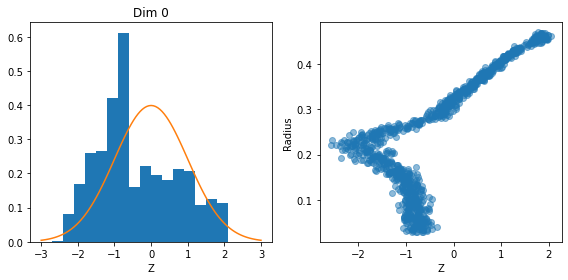

In [31]:
aeviz2 = AEViz(model_vae.enc, model_vae.dec, circles_dl)
fig, axs = plt.subplots(1, 2, figsize=(8, 4))
_ = aeviz2.plot_latent(ax=axs[1])
_ = aeviz2.plot_z_dist(n_cols=1, bins=np.linspace(-3, 3, 21), axs=axs[0])

### Reconstruction (VAE)

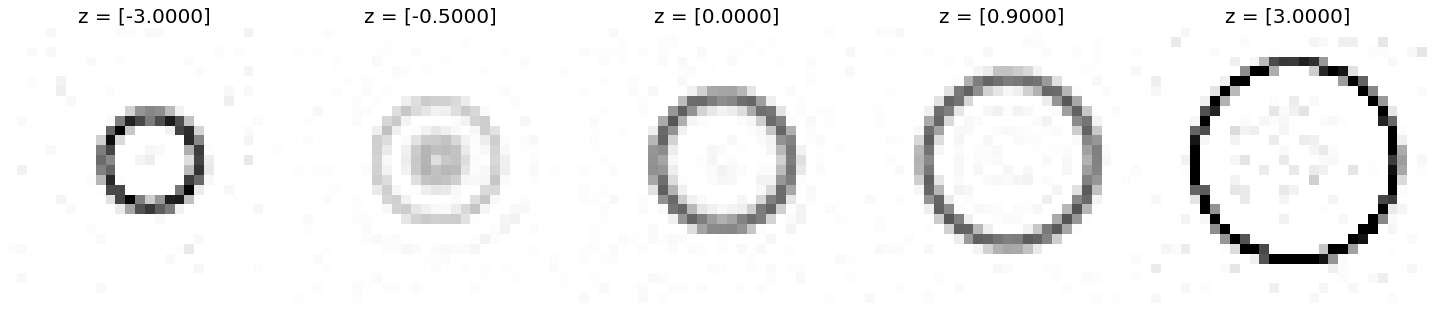

In [32]:
fig = figure4(model_vae, device)

## Convolutional Variational AutoeEncoder (CVAE)

In [33]:
set_seed(13)

z_size = 1
n_filters = 32
in_channels = 1
img_size = 28
input_shape = (in_channels, img_size, img_size)

base_model = nn.Sequential(
    # in_channels@28x28 -> n_filters@28x28
    nn.Conv2d(in_channels, n_filters, kernel_size=3, stride=1, padding=1),
    nn.LeakyReLU(),
            
    # n_filters@28x28 -> (n_filters*2)@14x14
    nn.Conv2d(n_filters, n_filters*2, kernel_size=3, stride=2, padding=1),
    nn.LeakyReLU(),
    
    # (n_filters*2)@14x14 -> (n_filters*2)@7x7
    nn.Conv2d(n_filters*2, n_filters*2, kernel_size=3, stride=2, padding=1),
    nn.LeakyReLU(),
    
    # (n_filters*2)@7x7 -> (n_filters*2)@7x7
    nn.Conv2d(n_filters*2, n_filters*2, kernel_size=3, stride=1, padding=1),
    nn.LeakyReLU(),
    
    # (n_filters*2)@7x7 -> (n_filters*2)*7*7
    nn.Flatten(),
)

encoder_var_cnn = EncoderVar(input_shape, z_size, base_model)

In [34]:
encoder_var_cnn

EncoderVar(
  (base_model): Sequential(
    (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): LeakyReLU(negative_slope=0.01)
    (2): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (3): LeakyReLU(negative_slope=0.01)
    (4): Conv2d(64, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (5): LeakyReLU(negative_slope=0.01)
    (6): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): LeakyReLU(negative_slope=0.01)
    (8): Flatten(start_dim=1, end_dim=-1)
  )
  (lin_mu): Linear(in_features=3136, out_features=1, bias=True)
  (lin_var): Linear(in_features=3136, out_features=1, bias=True)
)

In [43]:
decoder_cnn = nn.Sequential(
    # z_size -> (n_filters*2)*7*7
    nn.Linear(z_size, (n_filters*2)*int(img_size/4)**2),
    
    # (n_filters*2)*7*7 -> (n_filters*2)@7x7
    nn.Unflatten(1, (n_filters*2, int(img_size/4), int(img_size/4))),
    
    # (n_filters*2)@7x7 -> (n_filters*2)@7x7
    nn.ConvTranspose2d(n_filters*2, n_filters*2, kernel_size=3, stride=1, padding=1, output_padding=0),
    nn.LeakyReLU(),

    # (n_filters*2)@7x7 -> (n_filters*2)@14x14
    nn.ConvTranspose2d(n_filters*2, n_filters*2, kernel_size=3, stride=2, padding=1, output_padding=1),
    nn.LeakyReLU(),
    
    # (n_filters*2)@15x15 -> n_filters@28x28
    nn.ConvTranspose2d(n_filters*2, n_filters, kernel_size=3, stride=2, padding=1, output_padding=1),
    nn.LeakyReLU(),
    
    # n_filters@28x28 -> in_channels@28x28
    nn.ConvTranspose2d(n_filters, in_channels, kernel_size=3, stride=1, padding=1, output_padding=0),
    nn.Sigmoid(),
)

### Model Training (CVAE)

In [44]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
model_vae_cnn = AutoEncoder(encoder_var_cnn, decoder_cnn)
model_vae_cnn.to(device)
loss_fn = nn.MSELoss(reduction='none')
optim = torch.optim.Adam(model_vae_cnn.parameters(), 0.0003)

num_epochs = 30

train_losses = []

reconstruction_loss_factor = 1

for epoch in range(1, num_epochs+1):
    batch_losses = []
    for i, (x, _) in enumerate(circles_dl):
        model_vae_cnn.train()
        x = x.to(device)

        # Step 1 - Computes our model's predicted output - forward pass
        yhat = model_vae_cnn(x)

        # Step 2 - Computes the loss
        loss = loss_fn(yhat, x).sum(dim=[1, 2, 3]).sum(dim=0)
        kl_loss = model_vae_cnn.enc.kl_loss().sum(dim=1).sum(dim=0)
        total_loss = reconstruction_loss_factor * loss + kl_loss

        # Step 3 - Computes gradients
        total_loss.backward()

        # Step 4 - Updates parameters using gradients and the learning rate
        optim.step()
        optim.zero_grad()
        
        batch_losses.append(np.array([total_loss.data.item(), loss.data.item(), kl_loss.data.item()]))

    # Average over batches
    train_losses.append(np.array(batch_losses).mean(axis=0))

    print(f'Epoch {epoch:03d} | Loss >> {train_losses[-1][0]:.4f}/{train_losses[-1][1]:.4f}/{train_losses[-1][2]:.4f}')

Epoch 001 | Loss >> 2188.3729/2118.5622/69.8107
Epoch 002 | Loss >> 615.1194/611.0034/4.1160
Epoch 003 | Loss >> 559.5067/557.4889/2.0177
Epoch 004 | Loss >> 536.9767/534.6569/2.3198
Epoch 005 | Loss >> 528.8699/527.0321/1.8378
Epoch 006 | Loss >> 523.1928/522.2230/0.9698
Epoch 007 | Loss >> 520.0284/519.4467/0.5817
Epoch 008 | Loss >> 518.3346/517.9768/0.3578
Epoch 009 | Loss >> 515.3221/514.9059/0.4162
Epoch 010 | Loss >> 511.6769/511.1734/0.5036
Epoch 011 | Loss >> 504.5836/499.3259/5.2576
Epoch 012 | Loss >> 470.8952/445.0586/25.8367
Epoch 013 | Loss >> 433.3835/399.6353/33.7482
Epoch 014 | Loss >> 402.5835/359.6384/42.9452
Epoch 015 | Loss >> 369.1752/314.9096/54.2656
Epoch 016 | Loss >> 329.5333/271.1402/58.3931
Epoch 017 | Loss >> 294.9558/228.3881/66.5677
Epoch 018 | Loss >> 260.0648/189.2047/70.8601
Epoch 019 | Loss >> 228.3311/148.1844/80.1468
Epoch 020 | Loss >> 202.6253/121.7980/80.8273
Epoch 021 | Loss >> 189.0463/103.4763/85.5700
Epoch 022 | Loss >> 186.8962/101.1059/85.7

### Latent Space Distribution (CVAE)

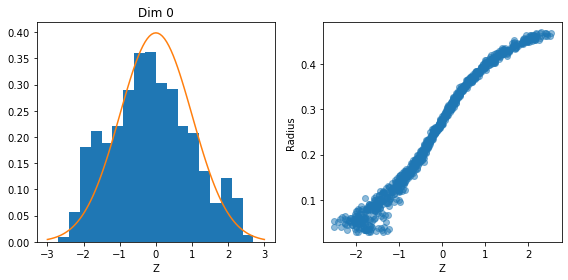

In [45]:
aeviz3 = AEViz(model_vae_cnn.enc, model_vae_cnn.dec, circles_dl)
fig, axs = plt.subplots(1, 2, figsize=(8, 4))
_ = aeviz3.plot_latent(ax=axs[1])
_ = aeviz3.plot_z_dist(n_cols=1, bins=np.linspace(-3, 3, 21), axs=axs[0])

### Reconstruction (CVAE)

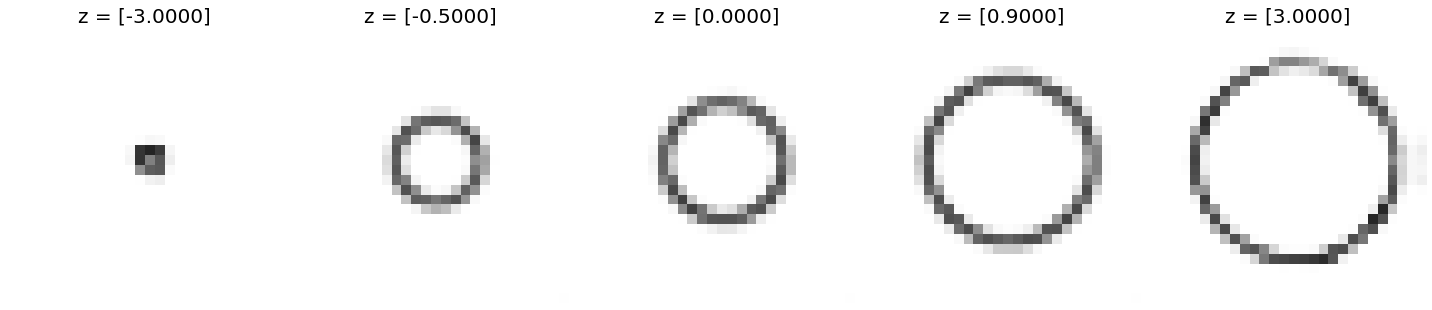

In [46]:
fig = figure4(model_vae_cnn, device)

## Further Reading

If you want to learn more about PyTorch, Computer Vision, and NLP, give my own series of books, "Deep Learning with PyTorch Step-by-Step", a try :-)

[![](https://github.com/dvgodoy/PyTorchStepByStep/raw/master/images/new_books.png)](https://pytorchstepbystep.com/)

# Bonus: [Transposed Convolutions](https://towardsdatascience.com/what-are-transposed-convolutions-2d43ac1a0771)

![convolution](images/autoencoders/conv8.png)

In [35]:
input_image = torch.ones((1, 1, 2, 2)) # N, C, H, W
input_image

tensor([[[[1., 1.],
          [1., 1.]]]])

In [36]:
kernel_size = 2
kernel = torch.ones((1, 1, kernel_size, kernel_size))
kernel

tensor([[[[1., 1.],
          [1., 1.]]]])

In [37]:
import torch.nn.functional as F

stride_transp = 1
padding_transp = 0

F.conv_transpose2d(input_image,
                   weight=kernel,
                   stride=stride_transp,
                   padding=padding_transp)

tensor([[[[1., 2., 1.],
          [2., 4., 2.],
          [1., 2., 1.]]]])

In [38]:
padding_implicit = kernel_size - padding_transp - 1
padded_image = F.pad(input_image, pad=[padding_implicit]*4)
padded_image

tensor([[[[0., 0., 0., 0.],
          [0., 1., 1., 0.],
          [0., 1., 1., 0.],
          [0., 0., 0., 0.]]]])

In [39]:
F.conv2d(padded_image, weight=kernel, stride=1)

tensor([[[[1., 2., 1.],
          [2., 4., 2.],
          [1., 2., 1.]]]])

![transposed convolution](images/autoencoders/conv_transp_s1.png)

In [40]:
stride_transp = 2
padding_transp = 0

F.conv_transpose2d(input_image,
                   weight=kernel,
                   stride=stride_transp,
                   padding=padding_transp)

tensor([[[[1., 1., 1., 1.],
          [1., 1., 1., 1.],
          [1., 1., 1., 1.],
          [1., 1., 1., 1.]]]])

In [41]:
zero_added_image = torch.tensor([[[[1, 0, 1],
                                   [0, 0, 0],
                                   [1, 0, 1]]]]).float()

In [42]:
padding_implicit = kernel_size - padding_transp - 1
stride = 1

F.conv2d(zero_added_image,
         weight=kernel,
         stride=1,
         padding=padding_implicit)

tensor([[[[1., 1., 1., 1.],
          [1., 1., 1., 1.],
          [1., 1., 1., 1.],
          [1., 1., 1., 1.]]]])

![transposed convolution](images/autoencoders/conv_transp_s2.png)

$$
\Large \text{stride}^T \times (\text{image_size}-1) + \text{kernel_size} - 2 \times \text{padding}^T
$$